This notebook shows work on creating a subclass of numpy.ndarray that would wrap a netCDF4 Variable. So far, it hasn't succeeded.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from kid_readout.measurement.io import nc

In [2]:
big_filename = '/data/readout/2016-04-09_103326_scan_lo_1010.0_MHz_mmw_modulated_7_7_turns.nc'

In [3]:
ds = netCDF4.Dataset(big_filename, mode='r')

In [4]:
len(ds.groups['SweepArray0'].groups['stream_arrays'].groups.keys())

1024

In [5]:
tone_index_var = ds.groups['SweepArray0'].groups['stream_arrays'].groups['0'].variables['tone_index']
tone_index_var

<type 'netCDF4._netCDF4.Variable'>
int64 tone_index(tone_index)
path = /SweepArray0/stream_arrays/0
unlimited dimensions: 
current shape = (32,)
filling on, default _FillValue of -9223372036854775806 used

In [6]:
tone_index = tone_index_var[:].view(tone_index_var.datatype.name).copy()
tone_index

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120, 124])

In [7]:
s21_raw_var = ds.groups['SweepArray0'].groups['stream_arrays'].groups['0'].variables['s21_raw']
s21_raw_var

<type 'netCDF4._netCDF4.Variable'>
compound s21_raw(tone_index, sample_time)
compound data type: {'names':[u'real',u'imag'], 'formats':['<f4','<f4'], 'offsets':[0,4], 'itemsize':8, 'aligned':True}
path = /SweepArray0/stream_arrays/0
unlimited dimensions: 
current shape = (32, 32768)

In [8]:
s21_raw = s21_raw_var[:].view(s21_raw_var.datatype.name).copy()
s21_raw

array([[ 120.50043488 +89.1720047j ,   94.83129883+100.08509064j,
         117.43099976 +95.69722748j, ...,  114.66867065 +83.97675323j,
         135.29034424 +79.88444519j,  112.32656860+115.67082977j],
       [ 126.09791565 -23.48013115j,  139.11842346 -28.42647171j,
         132.05662537 -13.45547009j, ...,  142.05241394 -12.41423512j,
         135.08958435 -21.4430294j ,  140.07717896 -18.42243195j],
       [ 122.10558319 +12.81511211j,  123.85943604 +19.59183693j,
         117.73206329 +11.88110828j, ...,  125.36273956 +25.40045738j,
         114.64540100 +19.91058731j,  119.30356598 +25.9356575j ],
       ..., 
       [  53.46964264  +6.40291166j,   43.78236008  +2.02609515j,
          33.10454559  +0.29858959j, ...,   37.32022095  -4.91946268j,
          51.47673798  -0.381506j  ,   42.71125793  +6.91002226j],
       [  32.79608154 -24.60522652j,   40.19738770 -16.4064064j ,
          26.79719543 -17.60427094j, ...,   35.19579315 -26.40560913j,
          37.19595337 -25.40592766

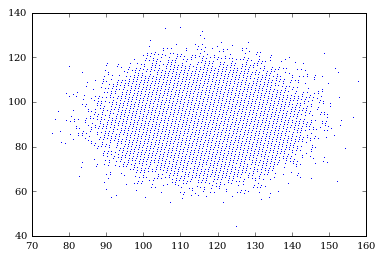

In [9]:
plt.plot(s21_raw[0].real, s21_raw[0].imag, ',')

In [89]:
class CachedArray(np.ndarray):
    
    def __new__(subtype, variable):
        a = np.ndarray.__new__(subtype, variable.shape, dtype=variable.datatype.name, buffer=None,
                               offset=0, strides=None, order=None)
        a._variable = variable
        a._data = None
        return a

#    def __array_finalize__(self, obj):
        
    @property
    def data(self):
        if self._data is None:
            self._data = self._variable[:].astype(self._variable.datatype.name).data
#            self._variable = None
        return self._data


class CachedArray2(np.ndarray):
    
    def __new__(subtype, variable):
        a = np.ndarray.__new__(subtype, variable.shape, dtype=variable.datatype.name, buffer=None,
                               offset=0, strides=None, order=None)
        a._variable = variable
        return a
    
    def __getitem__(self, item):
        if self._variable is not None:
            self.data = self._variable[:].astype(self._variable.datatype.name).data
        return super(CachedArray2, self).__getitem__(item)

In [90]:
ca = CachedArray(tone_index_var)

In [91]:
ca._variable

<type 'netCDF4._netCDF4.Variable'>
int64 tone_index(tone_index)
path = /SweepArray0/stream_arrays/0
unlimited dimensions: 
current shape = (32,)
filling on, default _FillValue of -9223372036854775806 used

In [103]:
# This seems to work fine
print(CachedArray2(tone_index_var))

[  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 124]


In [104]:
ca2 = CachedArray2(s21_raw_var)

In [105]:
ca2._variable

<type 'netCDF4._netCDF4.Variable'>
compound s21_raw(tone_index, sample_time)
compound data type: {'names':[u'real',u'imag'], 'formats':['<f4','<f4'], 'offsets':[0,4], 'itemsize':8, 'aligned':True}
path = /SweepArray0/stream_arrays/0
unlimited dimensions: 
current shape = (32, 32768)

In [106]:
ca2._variable is None

False

In [107]:
# I truly have no idea what's happening here
print(str(ca2))

AttributeError: 'CachedArray2' object has no attribute '_variable'